# Machine Learning em Atributos Estatísticos de Baixa Frequência

* `Artigo:` Measure Power Voltage Normalize Edge Detection Cluster Analysis Build Appliance Models Tabulate Statistics
* `URL`: https://www.semanticscholar.org/paper/Measure-Power-Voltage-Normalize-Edge-Detection-Deshmukh-Lohan/9156bffdc18946ceb3f4e6f56560b238c2fc931d
* `Source-code`: https://github.com/andydesh/nilm
* `Estratégia proposta`: "quebrar" série em *chunks* (janelas) de sub-séries, extrair características estatísticas e classificação supervisionada.

# Carregando ambiente e parâmetros

In [15]:
import csv, time, os, sys

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('ggplot')
plt.rc('text', usetex=False)
#plt.rc('font', family='serif')

from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

import pandas as pd
from scipy import interpolate

REDD_RESOURCES_PATH = 'datasets/REDD'
BENCHMARKING_RESOURCES_PATH = 'benchmarkings/cs446 project-electric-load-identification-using-machine-learning/'

sys.path.append(os.path.join(BENCHMARKING_RESOURCES_PATH, 'src'))
from MLData import createInstances, deviceErrors
from energyCalcs import actDevEnergy,appDevEnergy,energyComp

# Pré-processamento dos dados 

## Parâmetros gerais dos dados utilizados na modelagem (treino e teste)

In [2]:
datapath = os.path.join(REDD_RESOURCES_PATH, 'low_freq/house_3/')

# Dados climáticos (não disponibilizado  pelos autores - algoritmo adaptado)
weatherfile = 'Data/weather/20110405hourly_Boston.txt'
weatherfile_test = 'Data/weather/20110405hourly_Boston.txt'
available_weatherdata = True if os.path.isdir(weatherfile) else False

fileprefix = 'channel_'

# specify the timewindow for instances
timewindow = 90

# devices to be used in training and testing
use_idx = np.array([3,4,6,7,10,11,13,17,19])

## Gerando dados de Treino

Generating train data (from index 0 to 120001)...
Iter: 0 / Device: 3
Iter: 1 / Device: 4
Iter: 2 / Device: 6
Iter: 3 / Device: 7
Iter: 4 / Device: 10
Iter: 5 / Device: 11
Iter: 6 / Device: 13
Iter: 7 / Device: 17
Iter: 8 / Device: 19


C:\Users\diego\anaconda3\envs\doutorado\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


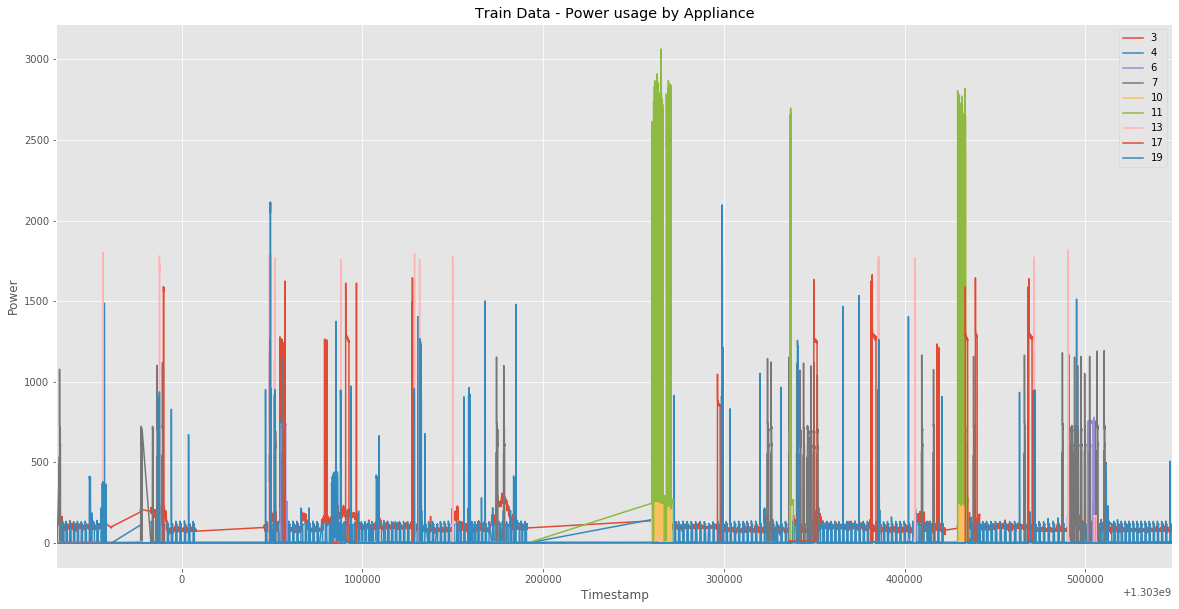

In [3]:
train_vals_start = 0
train_vals_end = 120001

# training data arrays
device_timer = np.zeros(shape=(train_vals_end - train_vals_start,9))
device_power = np.zeros(shape=(train_vals_end - train_vals_start,9))
total_device_power = np.zeros(shape=(train_vals_end - train_vals_start))

weather_timer = np.zeros(shape=(1980))
weather_temp = np.zeros(shape=(1980))
weather_data = np.zeros(shape=(train_vals_end - train_vals_start))

uidx = 0

print("Generating train data (from index {} to {})...".format(train_vals_start, train_vals_end))

# For each device (index), do...
fig = plt.figure(figsize=(20, 10))
for device in range(0, 20):
    
    # If the device is in our list of interest..
    if (device in use_idx):
        
        # Load energy data
        channel = device + 3
        filename = 'channel_'+ str(channel) +'.dat'
        filepath = datapath + filename

        # x = timestamp / y = energy
        xtemp, ytemp = np.loadtxt(filepath,unpack=True)
        
        print('Iter: {} / Device: {}'.format(uidx, device))
        device_timer[:, uidx] = xtemp[train_vals_start:train_vals_end]# - 1302930690
        device_power[:, uidx] = ytemp[train_vals_start:train_vals_end]
        total_device_power += ytemp[train_vals_start:train_vals_end]           

        
        plt.plot(device_timer[:,uidx], device_power[:,uidx])

        uidx = uidx + 1     

plt.title('Train Data - Power usage by Appliance')
plt.legend(use_idx)
plt.xlabel('Timestamp')
#ticks = xtemp[list(range(train_vals_start, train_vals_end-1, 10000)) + [train_vals_end]]
#plt.xticks(ticks, rotation='vertical')
plt.xlim(xtemp[train_vals_start], xtemp[train_vals_end])
plt.ylabel('Power')
plt.show()

################################################################
# read the weather data
if available_weatherdata:

    wfile = open(weatherfile,'rt')
    rownum = 0
    try:
        
        wreader = csv.reader(wfile, delimiter=',')
        for row in wreader:
            #print row[1]+','+row[2]+','+row[10]
            wdate = row[1]
            wtime = row[2]
            wdatelist = list(wdate)
            wtimelist = list(wtime)
            timedatestr = ''.join(wdatelist[0:4])+'-'+ ''.join(wdatelist[4:6])+'-'+''.join(wdatelist[6:8]) +'-'+ ''.join(wtimelist[0:2])+'-'+''.join(wtimelist[2:4])+'-'+'00'
            weather_timer[rownum] = int(time.mktime(time.strptime(timedatestr,"%Y-%m-%d-%H-%M-%S")))
            weather_temp[rownum] = int(row[10])
            #print str(weather_timer[rownum]) + ','+ str(weather_temp[rownum])
            rownum = rownum + 1
            
        interp_func = interpolate.interp1d(weather_timer, weather_temp)
        weather_data = interp_func(device_timer[:,0])

    finally:
        wfile.close

In [4]:
xtemp[list(range(train_vals_start, train_vals_end-1, 100)) + [train_vals_end]]

array([1.30293069e+09, 1.30293107e+09, 1.30293282e+09, ...,
       1.30354745e+09, 1.30354783e+09, 1.30354821e+09])

## Gerando dados de Teste

Generating test data (from index 120001 to 240002)...
Iter: 0 / Device: 3
Iter: 1 / Device: 4
Iter: 2 / Device: 6
Iter: 3 / Device: 7
Iter: 4 / Device: 10
Iter: 5 / Device: 11
Iter: 6 / Device: 13
Iter: 7 / Device: 17
Iter: 8 / Device: 19


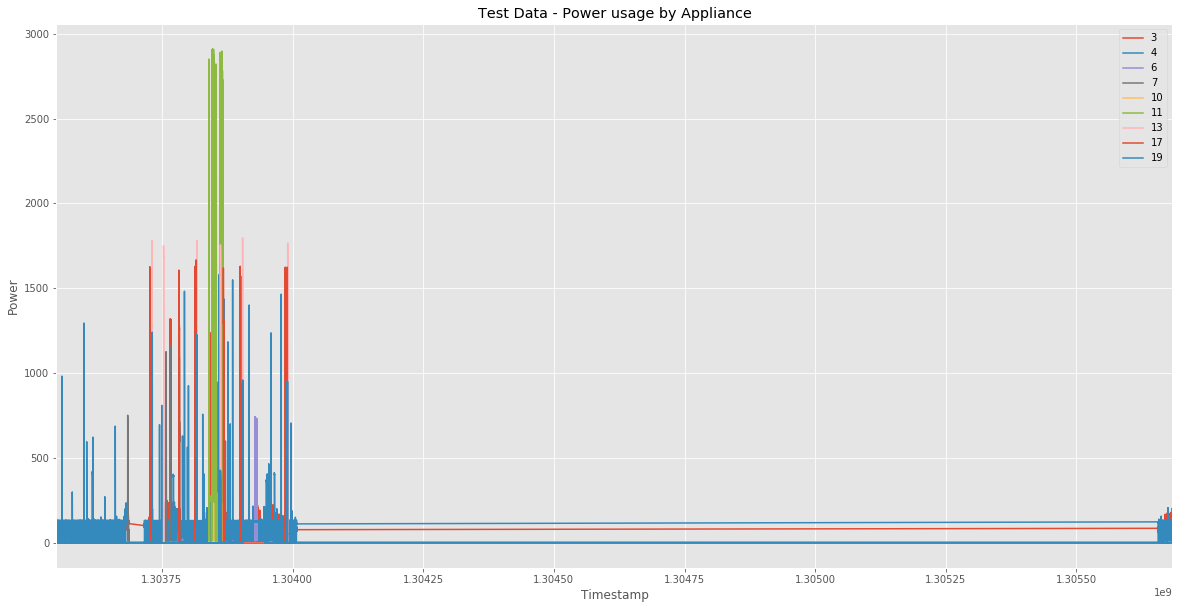

In [5]:
test_vals_start = 120001
test_vals_end = 240002

# test data arrays
device_timer_test = np.zeros(shape=(test_vals_end - test_vals_start, 9))
device_power_test = np.zeros(shape=(test_vals_end - test_vals_start, 9))
total_device_power_test = np.zeros(shape=(test_vals_end - test_vals_start))

weather_timer_test = np.zeros(shape= (1980))
weather_temp_test = np.zeros(shape= (1980))
weather_data_test = np.zeros(shape=(test_vals_end - test_vals_start))

uidx = 0

print("Generating test data (from index {} to {})...".format(test_vals_start, test_vals_end))

# For each device (index), do...
fig = plt.figure(figsize=(20, 10))
for device in range(0, 20):
    
    # If the device is in our list of interest..
    if (device in use_idx):
        
        # Load energy data
        channel = device + 3
        filename = 'channel_'+ str(channel) +'.dat'
        filepath = datapath + filename

        # x = timestamp / y = energy
        xtemp, ytemp = np.loadtxt(filepath,unpack=True)
        
        print('Iter: {} / Device: {}'.format(uidx, device))
        device_timer_test[:,uidx] = xtemp[test_vals_start:test_vals_end]# - 1302930690
        device_power_test[:,uidx] = ytemp[test_vals_start:test_vals_end]
        total_device_power_test += ytemp[test_vals_start:test_vals_end]  

        plt.plot(device_timer_test[:,uidx], device_power_test[:,uidx])

        uidx = uidx + 1     

plt.title('Test Data - Power usage by Appliance')
plt.legend(use_idx)
plt.xlabel('Timestamp')
#ticks = xtemp[list(range(test_vals_start, test_vals_end-1, 10000)) + [test_vals_end]]
#plt.xticks(ticks, rotation='vertical')
plt.xlim(xtemp[test_vals_start], xtemp[test_vals_end])
plt.ylabel('Power')
plt.show()

################################################################
# read the weather data
if available_weatherdata:

    wfile = open(weatherfile,'rt')
    rownum = 0
    try:
        
        wreader = csv.reader(wfile, delimiter=',')
        for row in wreader:
            #print row[1]+','+row[2]+','+row[10]
            wdate = row[1]
            wtime = row[2]
            wdatelist = list(wdate)
            wtimelist = list(wtime)
            timedatestr = ''.join(wdatelist[0:4])+'-'+ ''.join(wdatelist[4:6])+'-'+''.join(wdatelist[6:8]) +'-'+ ''.join(wtimelist[0:2])+'-'+''.join(wtimelist[2:4])+'-'+'00'
            weather_timer_test[rownum] = int(time.mktime(time.strptime(timedatestr,"%Y-%m-%d-%H-%M-%S")))
            weather_temp_test[rownum] = int(row[10])
            #print str(weather_timer[rownum]) + ','+ str(weather_temp[rownum])
            rownum = rownum + 1
            
        interp_func = interpolate.interp1d(weather_timer_test, weather_temp_test)
        weather_data_test = interp_func(device_timer_test[:,0])

    finally:
        wfile.close

## Extração de Características

In [6]:
################################################################
# create the instances and labels from the training data
classifier = 3 # 1 - Naive Bayes, 2 - Regression, 3 - SVM, 4 - Linear Discriminant Analysis, 5 - Random Forest Classifier

# Treino / Teste
print('Train -> ', end='')
train_instances, train_labels, train_labels_binary, train_power_chunks = createInstances(
    total_device_power, device_timer, device_power, weather_data,
    classifier,
    timewindow)

print('Test -> ', end='')
test_instances,test_labels,test_labels_binary, test_power_chunks = createInstances(
    total_device_power_test, device_timer_test, device_power_test, weather_data_test,
    classifier,
    timewindow)

Train -> instances: 4000
Test -> instances: 4000


## Persistência

In [43]:
from IPython.display import display

# Data persistence
np.save( os.path.join(BENCHMARKING_RESOURCES_PATH, 'datasets/train_instances.npy'), train_instances)
np.save( os.path.join(BENCHMARKING_RESOURCES_PATH, 'datasets/train_labels.npy'), train_labels)
np.save( os.path.join(BENCHMARKING_RESOURCES_PATH, 'datasets/train_labels_binary.npy'), train_labels_binary)
np.save( os.path.join(BENCHMARKING_RESOURCES_PATH, 'datasets/train_power_chunks.npy'), train_power_chunks)
np.save( os.path.join(BENCHMARKING_RESOURCES_PATH, 'datasets/test_instances.npy'), test_instances)
np.save( os.path.join(BENCHMARKING_RESOURCES_PATH, 'datasets/test_labels.npy'), test_labels)
np.save( os.path.join(BENCHMARKING_RESOURCES_PATH, 'datasets/test_labels_binary.npy'), test_labels_binary)
np.save( os.path.join(BENCHMARKING_RESOURCES_PATH, 'datasets/test_power_chunks.npy'), test_power_chunks)

# Dataframe DE TREINO com as estatísticas para cada chunk (projeto benchmarking analisado)
print('Benchmarking dataset...')
statistics = ["MEAN_POWER", "STD_POWER", "TIME_OF_DAY", "AMBIENT_TEMPERATURE", "PEAK_POWER", "ENERGY", "DAY_OF_WEEK"]
df_statistics = pd.DataFrame(
    np.concatenate([train_instances, train_labels_binary], axis=1),
    columns = statistics + ["APLIANCE_{}".format(i) for i in use_idx]
)
df_statistics.to_csv( os.path.join(BENCHMARKING_RESOURCES_PATH, 'datasets/df_statistics.csv') )
display(df_statistics.head())

# Dataframe com a carga da residencia e labels de aparelhos (usados para tese)
print('Thesis benchmarking dataset...')
df_power_chunks = pd.DataFrame(
    np.concatenate([train_power_chunks, train_labels_binary], axis=1),
    columns = ["POWER_{}".format(i) for i in range(train_power_chunks.shape[1])] + ["APLIANCE_{}".format(i) for i in use_idx]
)
df_power_chunks.to_csv( os.path.join(BENCHMARKING_RESOURCES_PATH, 'datasets/df_power_chunks.csv') )
display(df_power_chunks.head())

Benchmarking dataset...


,MEAN_POWER,STD_POWER,TIME_OF_DAY,AMBIENT_TEMPERATURE,PEAK_POWER,ENERGY,DAY_OF_WEEK,APLIANCE_3,APLIANCE_4,APLIANCE_6,APLIANCE_7,APLIANCE_10,APLIANCE_11,APLIANCE_13,APLIANCE_17,APLIANCE_19
0,254.233333,5.024496,4.0,0.0,267.0,27926.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,253.066667,3.463460,4.0,0.0,259.0,27864.5,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,207.433333,54.322913,4.0,0.0,266.0,22766.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,134.066667,2.448582,4.0,0.0,140.0,14860.5,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,627.000000,360.632315,4.0,0.0,1217.0,704625.5,5.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Thesis benchmarking dataset...


,POWER_0,POWER_1,POWER_2,POWER_3,POWER_4,POWER_5,POWER_6,POWER_7,POWER_8,POWER_9,...,POWER_29,APLIANCE_3,APLIANCE_4,APLIANCE_6,APLIANCE_7,APLIANCE_10,APLIANCE_11,APLIANCE_13,APLIANCE_17,APLIANCE_19
0,252.0,251.0,250.0,253.0,251.0,254.0,252.0,252.0,253.0,249.0,...,256.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,259.0,259.0,258.0,255.0,257.0,249.0,256.0,259.0,256.0,256.0,...,250.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,248.0,250.0,252.0,250.0,251.0,249.0,251.0,250.0,248.0,253.0,...,142.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,133.0,135.0,135.0,134.0,134.0,134.0,138.0,135.0,137.0,133.0,...,133.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,131.0,134.0,136.0,132.0,660.0,668.0,659.0,247.0,242.0,240.0,...,963.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Modelagem

## Benchmarking (replicando estudo)

In [8]:
for clf_idx in range (1,7):
    #clf = i
    if clf_idx == 1:
        cLabel = 'Naive Bayes'
        clf = MultinomialNB()
        MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
    
    elif clf_idx == 2:
        cLabel = 'Logistic Regression'
        clf = LogisticRegression()
        LogisticRegression(C = 1.0, penalty = 'l1', tol=1e-6)
    
    elif clf_idx == 3:
        cLabel = 'SVM'
        clf = SVC()
    
    elif clf_idx == 4:
        cLabel = 'Linear Discriminant Analysis'
        clf = LDA()
    
    elif clf_idx == 5:
        cLabel = 'Random Forest Classifier'
        clf = RandomForestClassifier(n_estimators=10)
        SVR(C = 1.0, epsilon=0.2)
    
    elif clf_idx ==6:
        cLabel = 'K-means clustering'
        clf = KMeans(n_clusters=512, init='random')
        

    t0 = time.time()
    clf.fit(train_instances, train_labels)   
    t1 = time.time()
    nd = len(use_idx)
    
    # prediction on training and test data
    accuracyTr, dev_acc_train, predicted_labels_binary_train = deviceErrors(
        clf,nd,train_instances,train_labels,train_labels_binary)
    accuracyTs, dev_acc_test, predicted_labels_binary_test = deviceErrors(
        clf,nd,test_instances,test_labels,test_labels_binary)
    
    # prediction of device energy consumption
    agg_energy_train = train_instances[:,5]
    actEnergy_train = actDevEnergy(device_power,device_timer,nd)
    appEnergy_train = appDevEnergy(train_labels_binary,agg_energy_train,nd)
    preEnergy_train = appDevEnergy(predicted_labels_binary_train,agg_energy_train,nd)

    acTap_train, acTpre_train, apTde_train = energyComp(actEnergy_train, appEnergy_train, preEnergy_train)

    agg_energy_test = test_instances[:,5]
    actEnergy_test = actDevEnergy(device_power_test,device_timer_test,nd)
    appEnergy_test = appDevEnergy(test_labels_binary,agg_energy_test,nd)
    preEnergy_test = appDevEnergy(predicted_labels_binary_test,agg_energy_test,nd)
  
    acTap_test, acTpre_test, apTde_test = energyComp(actEnergy_test, appEnergy_test, preEnergy_test)

  
    t2 = time.time()
    t3 = time.time()

    trainTime = t1-t0
    test1Time = t2-t1
    test2Time = t3-t2
    print( '================================================================================')
    print( 'Classifier = ' + cLabel)
    print( 'Computational Expense for Training Classifier = ' + str(trainTime)  + 's')
    print( '------------------------- Results for Traning Data -----------------------------')
    print( 'Percent Accuracy on Training Data = ' + str(accuracyTr) + '%')
    print( 'Percent Accuracy per device on Training Data = ' + str(dev_acc_train) + '%')
    print( 'Actual Device Energy on Training Data = ' +  str(actEnergy_train))
    print( 'Approx Device Energy on Training Data = ' +  str(appEnergy_train))
    print( 'Predicted Device Energy on Training Data = ' +  str(preEnergy_train))
    print( 'Computational Expense Classifying Training Data = ' + str(test1Time)  + 's')
    print( 'Device Accuracy Approx. vs Actual = ' + str(acTap_train))
    print( 'Device Accuracy Pre. vs. Actual = ' + str(acTpre_train))
    print( 'Device Accuracy Pre. vs. approx. = ' + str(apTde_train))
    print( '------------------------- Results for Test Data -----------------------------')
    print( 'Percent Accuracy on Test Data = ' + str(accuracyTs) + '%')
    print( 'Percent Accuracy per device on Test Data = ' + str(dev_acc_test) + '%')
    print( 'Actual Device Energy on Test Data = ' +  str(actEnergy_test))
    print( 'Approx Device Energy on Test Data = ' +  str(appEnergy_test))
    print( 'Predicted Device Energy on Test Data = ' +  str(preEnergy_test))
    print( 'Computational Expense Classifying Test Data = ' + str(test2Time)  + 's')
    print( 'Device Accuracy Approx. vs Actual = ' + str(acTap_test))
    print( 'Device Accuracy Pre. vs. Actual = ' + str(acTpre_test))
    print( 'Device Accuracy Pre. vs. approx. = ' + str(apTde_test))
    print('\n\n')

Classifier = Naive Bayes
Computational Expense for Training Classifier = 0.005944728851318359s
------------------------- Results for Traning Data -----------------------------
Percent Accuracy on Training Data = 27.849999999999998%
Percent Accuracy per device on Training Data = [53.15  62.975 95.05  90.35  97.5   85.95  94.75  94.25  92.225]%
Actual Device Energy on Training Data = [66120450.   27392535.5   4449121.5  19128794.5  15390170.   28580011.25
  4341837.5  15216350.25  5500048.25]
Approx Device Energy on Training Data = [61753506.44166666 45844281.02500001  2540501.39583333 12911220.4
 15640700.5125     17332266.62916667  1987370.3125      9165130.67916667
  2994102.60416667]
Predicted Device Energy on Training Data = [34506972.77916667 29000747.00833333  2893159.52083333 18142838.57083333
  5318590.91666667 22028142.44583333  7095129.125      12302105.8625
 13416221.27083333]
Computational Expense Classifying Training Data = 0.11170125007629395s
Device Accuracy Approx. vs Ac

C:\Users\diego\anaconda3\envs\doutorado\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\diego\anaconda3\envs\doutorado\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\diego\anaconda3\envs\doutorado\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\diego\anaconda3\envs\doutorado\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.

Classifier = Logistic Regression
Computational Expense for Training Classifier = 2.19213604927063s
------------------------- Results for Traning Data -----------------------------
Percent Accuracy on Training Data = 37.475%
Percent Accuracy per device on Training Data = [57.25  75.35  98.275 93.875 97.4   96.125 98.875 96.675 97.925]%
Actual Device Energy on Training Data = [66120450.   27392535.5   4449121.5  19128794.5  15390170.   28580011.25
  4341837.5  15216350.25  5500048.25]
Approx Device Energy on Training Data = [61753506.44166666 45844281.02500001  2540501.39583333 12911220.4
 15640700.5125     17332266.62916667  1987370.3125      9165130.67916667
  2994102.60416667]
Predicted Device Energy on Training Data = [9.07359962e+07 5.03644887e+07 6.01085000e+04 8.81436421e+05
 1.57066301e+07 1.64512647e+07 5.02842500e+04 6.06406190e+06
 0.00000000e+00]
Computational Expense Classifying Training Data = 0.10471844673156738s
Device Accuracy Approx. vs Actual = [ 6.60452789 67.36048777

C:\Users\diego\anaconda3\envs\doutorado\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Classifier = Random Forest Classifier
Computational Expense for Training Classifier = 0.06682038307189941s
------------------------- Results for Traning Data -----------------------------
Percent Accuracy on Training Data = 99.52499999999999%
Percent Accuracy per device on Training Data = [ 99.6    99.85   99.975  99.975 100.    100.    100.     99.975 100.   ]%
Actual Device Energy on Training Data = [66120450.   27392535.5   4449121.5  19128794.5  15390170.   28580011.25
  4341837.5  15216350.25  5500048.25]
Approx Device Energy on Training Data = [61753506.44166666 45844281.02500001  2540501.39583333 12911220.4
 15640700.5125     17332266.62916667  1987370.3125      9165130.67916667
  2994102.60416667]
Predicted Device Energy on Training Data = [61652828.81666667 45835146.58749999  2492966.64583333 12919162.4
 15663337.95       17354904.06666667  2004548.75        9189083.74166667
  3011281.04166667]
Computational Expense Classifying Training Data = 0.14466571807861328s
Device Accur

C:\Users\diego\anaconda3\envs\doutorado\lib\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (511) found smaller than n_clusters (512). Possibly due to duplicate points in X.
  return_n_iter=True)


Classifier = K-means clustering
Computational Expense for Training Classifier = 5.234997034072876s
------------------------- Results for Traning Data -----------------------------
Percent Accuracy on Training Data = 0.024999999999997247%
Percent Accuracy per device on Training Data = [51.    45.075 50.35  48.725 47.1   49.875 49.275 48.825 52.525]%
Actual Device Energy on Training Data = [66120450.   27392535.5   4449121.5  19128794.5  15390170.   28580011.25
  4341837.5  15216350.25  5500048.25]
Approx Device Energy on Training Data = [61753506.44166666 45844281.02500001  2540501.39583333 12911220.4
 15640700.5125     17332266.62916667  1987370.3125      9165130.67916667
  2994102.60416667]
Predicted Device Energy on Training Data = [17822244.67668652 16445840.75228174 17111516.23382936 15263334.53799602
 22829382.55704365 18997941.63799604 18081736.88412698 26201060.61448411
 28186534.10555555]
Computational Expense Classifying Training Data = 0.1855030059814453s
Device Accuracy Appr

In [9]:
# # compute the energy consumption of each device.
    
# ################################################################
# #plot 4 of the devices for illustration
# fig = plt.figure(0)
# lendev = len(device_timer[:,0])
# ax1 = plt.subplot(221)
# plt.plot((device_timer[:,0]-device_timer[0,0])/(device_timer[lendev-1,0]-device_timer[0,0]),device_power[:,0])
# ax1.set_title('Electronics')
# plt.ylabel('Device Power (W)')

# ax2 = plt.subplot(222)
# plt.plot((device_timer[:,0]-device_timer[0,0])/(device_timer[lendev-1,0]-device_timer[0,0]),device_power[:,1])
# ax2.set_title('Refrigerator')
# #plt.ylabel('Device Power (W)')

# ax3 = plt.subplot(223)
# plt.plot((device_timer[:,0]-device_timer[0,0])/(device_timer[lendev-1,0]-device_timer[0,0]),device_power[:,3])
# ax3.set_title('Furnace')
# plt.xlabel('Normalized Time')
# plt.ylabel('Device Power (W)')

# ax4 = plt.subplot(224)
# plt.plot((device_timer[:,0]-device_timer[0,0])/(device_timer[lendev-1,0]-device_timer[0,0]),device_power[:,5])
# ax4.set_title('Washer Dryer 2')
# plt.xlabel('Normalized Time')
# #plt.ylabel('Device Power (W)')

# fig = plt.figure(1)
# plt.plot((device_timer[0:288,0]-device_timer[0,0])/(device_timer[288-1,0]-device_timer[0,0]),device_power[0:288,0])


# plt.show()
# plt.ylabel('Mains Power Consumption (W)')
# plt.xlabel('time (s)')

# Conclusões

Foi possível reproduzir o experimento conduzido no projeto `CS446 Project: Electric Load Identification using Machine Learning`, onde se extrai atributos para cada subset (chunks) de séries temporais de medições de energia residencial de baixa frequência, tais como:

    * Average power instance        
    * Std deviation of power        
    * Local hour of the day fraction
    * Local average temperature during the 5 minute window
    * Maximum power reading
    * The energy (integral of power) reading
    * Day of the week 

Todavia, no processo de implementação foram detectadas algumas limitações, destacando-se:

    1. O autor não compartilhou os dados metereológicos utilizados no estudo. Sobre esta questão, a saída foi adaptar o algoritmo para pré-processar os dados de modo que ignora-se este atributo;
    2. Muitas inconsitências na implementação, como a definição do intervalo de medição a partir do cabeçãlho da série. Este é um ponto problemático, uma vez que as medições individuais dos aparelhos não estão normalizadas por padrão, e o intervalo pode sofrer variação (como ocorre no conjunto de TESTE, que resultou em um `timestep` de 9 unidades (diferente dos 3 (segundos) existentes na corrente principal da casa. 
    
Sendo assim, um ponto de evolução é implementar a extração de características a partir do pacote `NILMTK`, que permite processar os dados mantendo a integridade das informações. Por ora, foi fixado o `timestep` em 3 segundos (sampling_rate) no código do projeto (mais especificamente na linha 14 do arquivo *PROJETO_PATH/src/MLData.py*).
    

In [10]:
# timestep = device_timer[2, 1] - device_timer[1, 1]
# print('timestep: {}'.format(timestep))

# numdata = len(total_device_power)
# print('numdata: {}'.format(numdata))

# numdevices = len(device_power[0])
# print('numdevices: {}'.format(numdevices))

# idxstep = int(timewindow/timestep)
# print('idxstep: {}'.format(idxstep))

# numinstances = int(numdata/idxstep)
# print('numinstances: {}'.format(numinstances))

# binarylabels = np.zeros(shape=(numinstances,numdevices),dtype=np.int)
# print('binarylabels: {}'.format(binarylabels.shape))

In [11]:
# Timestep inconsistence
device_timer_test[2, 1] - device_timer_test[1, 1]

9.0

In [14]:
train_instances.shape

(4000, 7)

In [13]:
test_instances.shape

(4000, 7)